# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/home/guy/datasets/'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

Found mnist Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

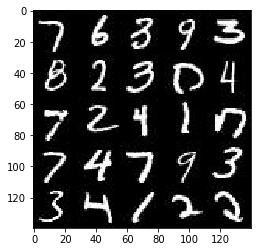

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

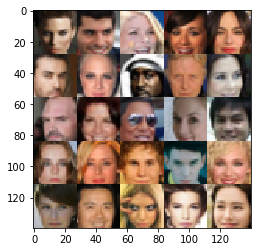

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,[None,image_height,image_width,image_channels])
    inputs_z = tf.placeholder(tf.float32,[None,z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real,inputs_z,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/guy/anaconda3/envs/dlnd/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/guy/anaconda3/envs/dlnd/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/guy/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/guy/anaconda3/envs/dlnd/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/guy/anaconda3/envs/dlnd/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/guy/anaconda3/envs/dlnd/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [30]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.15   # coefficient for leaky relu
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # layer 1: input = 28x28x3
        x = tf.layers.conv2d(images,32,5,2,padding='same',kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))  # now 14x14x32
        # x = tf.layers.batch_normalization(x,training=True)
        x = tf.maximum(alpha*x,x)
        # x = tf.nn.dropout(x,0.5)
        # now 14x14x32

        x = tf.layers.conv2d(x,64,1,1,padding='same',kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))   # now 7x7x64
        x = tf.layers.batch_normalization(x,training=True)
        x = tf.maximum(alpha * x, x)
        
        
#        x = tf.layers.conv2d(x,128,5,2,padding='same',kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))   # now 7x7x64
#        x = tf.layers.batch_normalization(x,training=True)
#        x = tf.maximum(alpha * x, x)

        #layer 2: input = 7x7x64
#        x = tf.layers.conv2d(x,256,5,2,padding='same',kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))  # now 4x4x128
#        x = tf.layers.batch_normalization(x,training=True)
#        x = tf.maximum(alpha * x, x)

        #layer 2: input = 4x4x128
#        x = tf.layers.conv2d(x,512,3,2,padding='same',kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))  # now 2x2x256
#        x = tf.layers.batch_normalization(x,training=True)
#        x = tf.maximum(alpha * x, x)

        x_flat = tf.contrib.layers.flatten(x)

        logits = tf.layers.dense(x_flat,1,kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))
        out = tf.sigmoid(logits)
    return logits,out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [31]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.15  # coefficient for leaky relu
    # reuse of (trained) weights is needed when we want to generate images i.e. during inference
    # thus the reuse flag should be opposite to is_train
    with tf.variable_scope('generator', reuse=not is_train):
        # x = tf.layers.dense(z, 2 * 2 * 512,kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))
        # x = tf.reshape(x, (-1, 2, 2, 512))  # now the tensor is [N,2,2,256]
        x = tf.layers.dense(z, 7*7* 64,kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))
        x = tf.reshape(x, (-1, 7, 7, 64))  # now the tensor is [N,2,2,256]
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # x = tf.nn.dropout(x, 0.5)

        x = tf.layers.conv2d_transpose(x, 32, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))  # now the tensor is [N,4,4,128]
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)


        # Layer 2:
#        x = tf.layers.conv2d_transpose(x, 128, 4, 1, padding='valid',kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))  # now the tensor is [N,7,7,64]
#        x = tf.layers.batch_normalization(x, training=is_train)
#        x = tf.maximum(alpha * x, x)
        # x = tf.nn.dropout(x, 0.5)

        # Layer 3:
#        x = tf.layers.conv2d_transpose(x, 64, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))  # now the tensor is [N,14,14,32]
#        x = tf.layers.batch_normalization(x, training=is_train)
#        x = tf.maximum(alpha * x, x)

        # Layer 3:
#        x = tf.layers.conv2d_transpose(x, 32, 1, 1, padding='same',kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))  # now the tensor is [N,14,14,32]
#        x = tf.layers.batch_normalization(x, training=is_train)
#        x = tf.maximum(alpha * x, x)
        
        
        # Layer 4: the last layer to bring it to image size of 28x28
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(mean=0,stddev=0.02))

        out = tf.tanh(logits)

    return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [25]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.0
    # define a generator network
    input_fake = generator(input_z,out_channel_dim,is_train=True)

    # define a discriminator that gets fake
    d_out_fake,d_logits_fake = discriminator(input_fake)

    # define a discriminator that gets real
    d_out_real,d_logits_real = discriminator(input_real,reuse=True)

    # define loss_d_real - the loss for real images - should be compared to ones
    loss_d_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_out_real)*(1.0-smooth)))
    # define loss_d_fake - the loss for the fake images - should be compared to zeros
    loss_d_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_out_fake)))

    loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_out_fake)))
    # define loss_g as the opposite of loss_d_fake. i.e. should be compared to ones
    loss_d=loss_d_real + loss_d_fake

    return loss_d, loss_g


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [26]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss,var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss,var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    input_real, input_z, lr = model_inputs(data_shape[2],data_shape[1],data_shape[3],z_dim)
    d_loss, g_loss = model_loss(input_real,input_z,data_shape[3])
    d_opt,g_opt = model_opt(d_loss,g_loss,lr,beta1)
    # train the model
    saver = tf.train.Saver()
    losses=[]
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2.0
                # Sample random noise for G
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                # batch_z = np.random.normal(0.0, 1.0, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt,feed_dict={input_real:batch_images,input_z:batch_z, lr:learning_rate})
                _ = sess.run(g_opt,feed_dict={input_real:batch_images,input_z:batch_z,lr:learning_rate})
                _ = sess.run(g_opt,feed_dict={input_real:batch_images,input_z:batch_z,lr:learning_rate})

                if steps % 10 ==0:
                    train_loss_d = d_loss.eval({input_z:batch_z,input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 ==0:
                    show_generator_output(sess,25,input_z,data_shape[3],data_image_mode)

        saver.save(sess,'./checkpoints/generator.ckpt')
    return losses
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4548... Generator Loss: 0.4120
Epoch 1/2... Discriminator Loss: 1.4825... Generator Loss: 0.3980
Epoch 1/2... Discriminator Loss: 1.5054... Generator Loss: 0.3995
Epoch 1/2... Discriminator Loss: 1.4818... Generator Loss: 0.4209
Epoch 1/2... Discriminator Loss: 1.4582... Generator Loss: 0.4417
Epoch 1/2... Discriminator Loss: 1.4452... Generator Loss: 0.4469
Epoch 1/2... Discriminator Loss: 1.4299... Generator Loss: 0.4610
Epoch 1/2... Discriminator Loss: 1.4185... Generator Loss: 0.4723
Epoch 1/2... Discriminator Loss: 1.4155... Generator Loss: 0.4888
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 0.5215


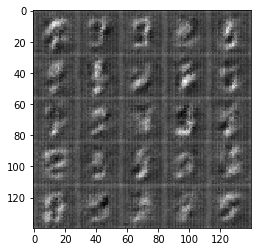

Epoch 1/2... Discriminator Loss: 1.3960... Generator Loss: 0.5456
Epoch 1/2... Discriminator Loss: 1.3883... Generator Loss: 0.5558
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 0.5673
Epoch 1/2... Discriminator Loss: 1.3835... Generator Loss: 0.5782
Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.5992
Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 0.6071
Epoch 1/2... Discriminator Loss: 1.3832... Generator Loss: 0.6124
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.6165
Epoch 1/2... Discriminator Loss: 1.3832... Generator Loss: 0.6135
Epoch 1/2... Discriminator Loss: 1.3808... Generator Loss: 0.6130


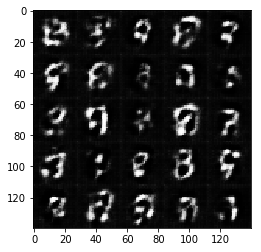

Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 0.6187
Epoch 1/2... Discriminator Loss: 1.3833... Generator Loss: 0.6238
Epoch 1/2... Discriminator Loss: 1.3821... Generator Loss: 0.6217
Epoch 1/2... Discriminator Loss: 1.3802... Generator Loss: 0.6293
Epoch 1/2... Discriminator Loss: 1.3818... Generator Loss: 0.6173
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.6392
Epoch 1/2... Discriminator Loss: 1.3815... Generator Loss: 0.6023
Epoch 1/2... Discriminator Loss: 1.3879... Generator Loss: 0.6119
Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 0.6502
Epoch 1/2... Discriminator Loss: 1.3832... Generator Loss: 0.6525


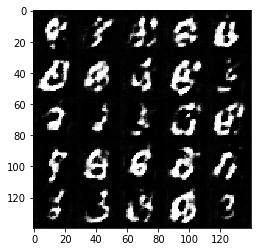

Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.6257
Epoch 1/2... Discriminator Loss: 1.3780... Generator Loss: 0.6166
Epoch 1/2... Discriminator Loss: 1.3834... Generator Loss: 0.6317
Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 0.6453
Epoch 1/2... Discriminator Loss: 1.3836... Generator Loss: 0.6250
Epoch 1/2... Discriminator Loss: 1.3783... Generator Loss: 0.6185
Epoch 1/2... Discriminator Loss: 1.3856... Generator Loss: 0.6248
Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 0.6170
Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 0.6351
Epoch 1/2... Discriminator Loss: 1.3775... Generator Loss: 0.6324


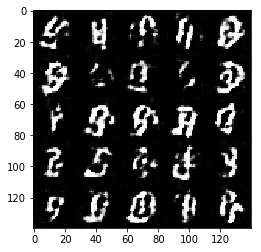

Epoch 1/2... Discriminator Loss: 1.3875... Generator Loss: 0.6291
Epoch 1/2... Discriminator Loss: 1.3795... Generator Loss: 0.6089
Epoch 1/2... Discriminator Loss: 1.3909... Generator Loss: 0.6197
Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 0.6302
Epoch 1/2... Discriminator Loss: 1.3820... Generator Loss: 0.6289
Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.6226
Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 0.6098
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.6277
Epoch 2/2... Discriminator Loss: 1.3746... Generator Loss: 0.6191
Epoch 2/2... Discriminator Loss: 1.3801... Generator Loss: 0.6280


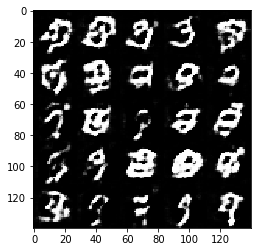

Epoch 2/2... Discriminator Loss: 1.3839... Generator Loss: 0.5988
Epoch 2/2... Discriminator Loss: 1.3651... Generator Loss: 0.5931
Epoch 2/2... Discriminator Loss: 1.3830... Generator Loss: 0.6548
Epoch 2/2... Discriminator Loss: 1.3692... Generator Loss: 0.6135
Epoch 2/2... Discriminator Loss: 1.3800... Generator Loss: 0.6297
Epoch 2/2... Discriminator Loss: 1.3810... Generator Loss: 0.5932
Epoch 2/2... Discriminator Loss: 1.3726... Generator Loss: 0.5768
Epoch 2/2... Discriminator Loss: 1.3793... Generator Loss: 0.6300
Epoch 2/2... Discriminator Loss: 1.3936... Generator Loss: 0.5974
Epoch 2/2... Discriminator Loss: 1.3695... Generator Loss: 0.5877


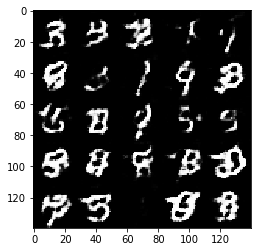

Epoch 2/2... Discriminator Loss: 1.3747... Generator Loss: 0.6111
Epoch 2/2... Discriminator Loss: 1.3793... Generator Loss: 0.5901
Epoch 2/2... Discriminator Loss: 1.3784... Generator Loss: 0.6065
Epoch 2/2... Discriminator Loss: 1.3758... Generator Loss: 0.6127
Epoch 2/2... Discriminator Loss: 1.3825... Generator Loss: 0.6049
Epoch 2/2... Discriminator Loss: 1.3677... Generator Loss: 0.6256
Epoch 2/2... Discriminator Loss: 1.3741... Generator Loss: 0.6161
Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 0.6108
Epoch 2/2... Discriminator Loss: 1.3851... Generator Loss: 0.6032
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.6288


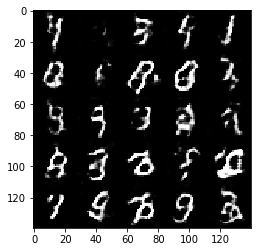

Epoch 2/2... Discriminator Loss: 1.3599... Generator Loss: 0.6207
Epoch 2/2... Discriminator Loss: 1.3798... Generator Loss: 0.6179
Epoch 2/2... Discriminator Loss: 1.3892... Generator Loss: 0.5982
Epoch 2/2... Discriminator Loss: 1.3817... Generator Loss: 0.6093
Epoch 2/2... Discriminator Loss: 1.3825... Generator Loss: 0.5883
Epoch 2/2... Discriminator Loss: 1.3802... Generator Loss: 0.5901
Epoch 2/2... Discriminator Loss: 1.3769... Generator Loss: 0.6262
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 0.5789
Epoch 2/2... Discriminator Loss: 1.3833... Generator Loss: 0.5789
Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 0.6141


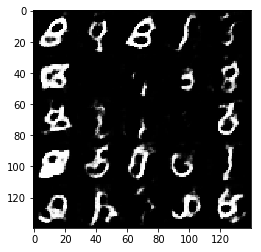

Epoch 2/2... Discriminator Loss: 1.3789... Generator Loss: 0.6207
Epoch 2/2... Discriminator Loss: 1.3773... Generator Loss: 0.6113
Epoch 2/2... Discriminator Loss: 1.3834... Generator Loss: 0.5850
Epoch 2/2... Discriminator Loss: 1.3811... Generator Loss: 0.5845
Epoch 2/2... Discriminator Loss: 1.3786... Generator Loss: 0.5916
Epoch 2/2... Discriminator Loss: 1.3718... Generator Loss: 0.6035
Epoch 2/2... Discriminator Loss: 1.3655... Generator Loss: 0.5937
Epoch 2/2... Discriminator Loss: 1.3865... Generator Loss: 0.5826
Epoch 2/2... Discriminator Loss: 1.3891... Generator Loss: 0.5798
Epoch 2/2... Discriminator Loss: 1.3754... Generator Loss: 0.5949


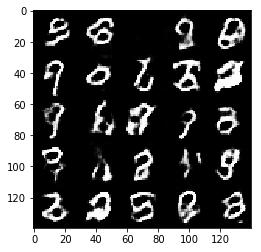

Epoch 2/2... Discriminator Loss: 1.3718... Generator Loss: 0.6190
Epoch 2/2... Discriminator Loss: 1.3731... Generator Loss: 0.6086
Epoch 2/2... Discriminator Loss: 1.3621... Generator Loss: 0.5957


In [32]:
batch_size = 128
z_dim = 60
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.4138
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.3964
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.3943
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.4111
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.4207
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.4674
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.4954
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.5319
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.5424


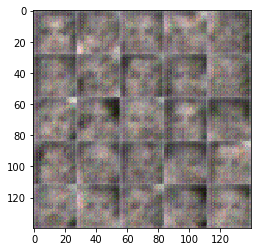

Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.6815


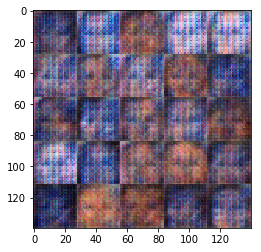

Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6885


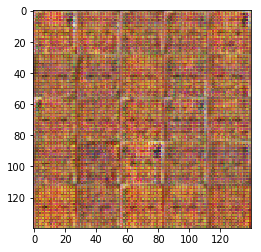

Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6913


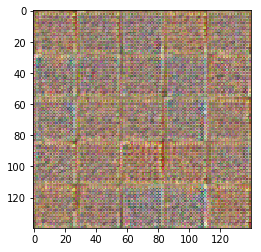

Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6921


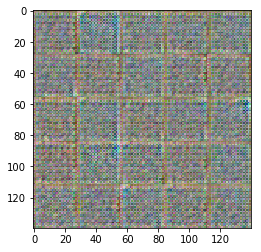

Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6925


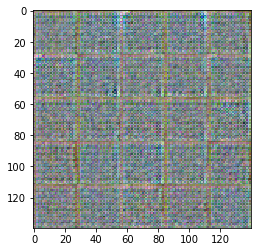

Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6928


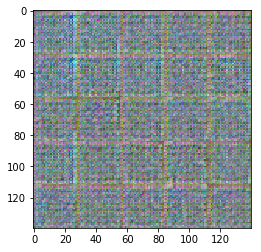

Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6929


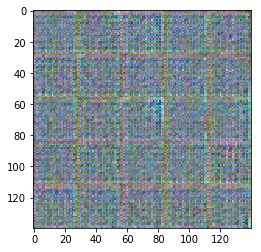

Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6929


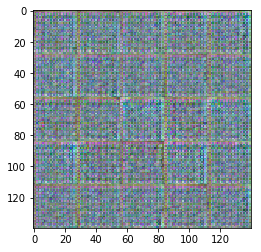

Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6930


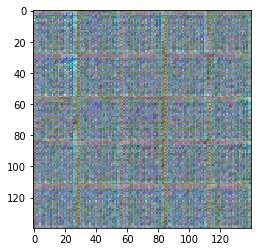

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930


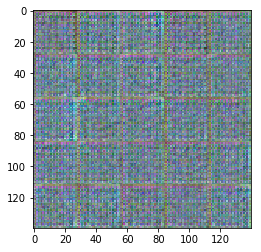

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930


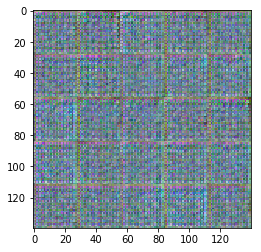

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931


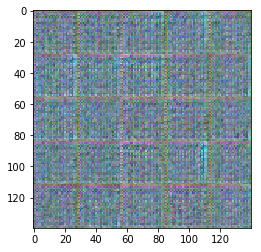

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931


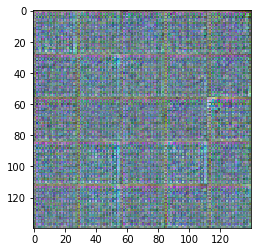

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931


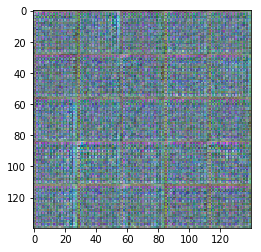

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6931


In [34]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.